In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-10-11 11:08:46.478389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 11:08:46.478409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [24]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from librep.metrics.report import ClassificationReport
import yaml

In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../data/old-views/KuHar/resampled_view_20Hz")

In [4]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [5]:
train.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1


In [6]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

In [7]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [8]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [9]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [10]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


In [11]:
print(np.max(train_dataset_fft.X))

1182.4630044066


In [12]:
train_dataset_fft.X

array([[2.08923330e-02, 1.12081089e-01, 6.03699767e-02, ...,
        6.86907330e-03, 1.25349286e-02, 1.69158661e-02],
       [1.53802877e-02, 8.24343989e-02, 4.18766153e-02, ...,
        3.72912157e-03, 3.98584265e-03, 1.71193131e-02],
       [5.21272671e-02, 4.82816195e-02, 8.93573044e-02, ...,
        9.75422945e-03, 2.66463902e-02, 7.84359780e-03],
       ...,
       [2.46594280e+00, 2.97792077e+01, 2.58438841e+01, ...,
        1.43625028e+00, 7.98405975e-01, 2.66617405e-01],
       [3.12703194e+00, 2.12859482e+01, 9.31637610e+00, ...,
        4.71804217e-01, 9.06413206e-01, 6.75740676e-01],
       [1.48890233e+01, 6.63385820e+00, 8.58902995e+00, ...,
        3.19953749e-01, 1.27100790e-01, 3.83110579e-01]])

In [13]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

# Applying Scaler

In [14]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()
# train_scaled = scaler.fit_transform(train_dataset_fft.X)
# test_scaled = scaler.fit_transform(test_dataset_fft.X)

In [15]:
# np.min(train_scaled), np.max(test_scaled)

(0.0, 1.0000000000000002)

In [16]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# test_Y = test_dataset_fft.y

# Reducing with UMAP

In [17]:
from librep.transforms import UMAP
transformer = UMAP()
transformer.fit(train_dataset_fft.X, train_dataset_fft.y)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

## Computing accuracy values

# Generic AE

The topological autoencoder can be used as a generic one by applying a lambda value of 0.

In [18]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2',
                                               lam=0, ae_kwargs=kwargs,
                                               input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:0.0056, Loss-ae:0.0056, Loss-topo:0.0369
Epoch:2, P:10, Loss:0.0049, Loss-ae:0.0049, Loss-topo:0.0218
Epoch:3, P:10, Loss:0.0033, Loss-ae:0.0033, Loss-topo:0.0154
Epoch:4, P:10, Loss:0.0032, Loss-ae:0.0032, Loss-topo:0.0175
Epoch:5, P:10, Loss:0.0031, Loss-ae:0.0031, Loss-topo:0.0147
Epoch:6, P:10, Loss:0.0031, Loss-ae:0.0031, Loss-topo:0.0132
Epoch:7, P:9, Loss:0.0027, Loss-ae:0.0027, Loss-topo:0.0166
Epoch:8, P:10, Loss:0.0025, Loss-ae:0.0025, Loss-topo:0.0168
Epoch:9, P:10, Loss:0.0028, Loss-ae:0.0028, Loss-topo:0.0159
Epoch:10, P:9, Loss:0.0025, Loss-ae:0.0025, Loss-topo:0.0148
Epoch:11, P:8, Loss:0.0025, Loss-ae:0.0025, Loss-topo:0.0217
Epoch:12, P:10, Loss:0.0024, Loss-ae:0.0024, Loss-topo:0.0218
Epoch:13, P:10, Loss:0.0025, Loss-ae:0.0025, Loss-topo:0.0174
Epoch:14, P:9, Loss:0.0025, Loss-ae:0.0025, Loss-topo:0.0518
Epoch:15, P:8, Loss:0.0024, Loss-ae:0.0024, Loss-topo:0.0184
Epoch:16, P:10, Loss:0.0024, Loss-ae:0.0024, Loss-topo:0.0234
Epoch:17, P:10, Loss:0

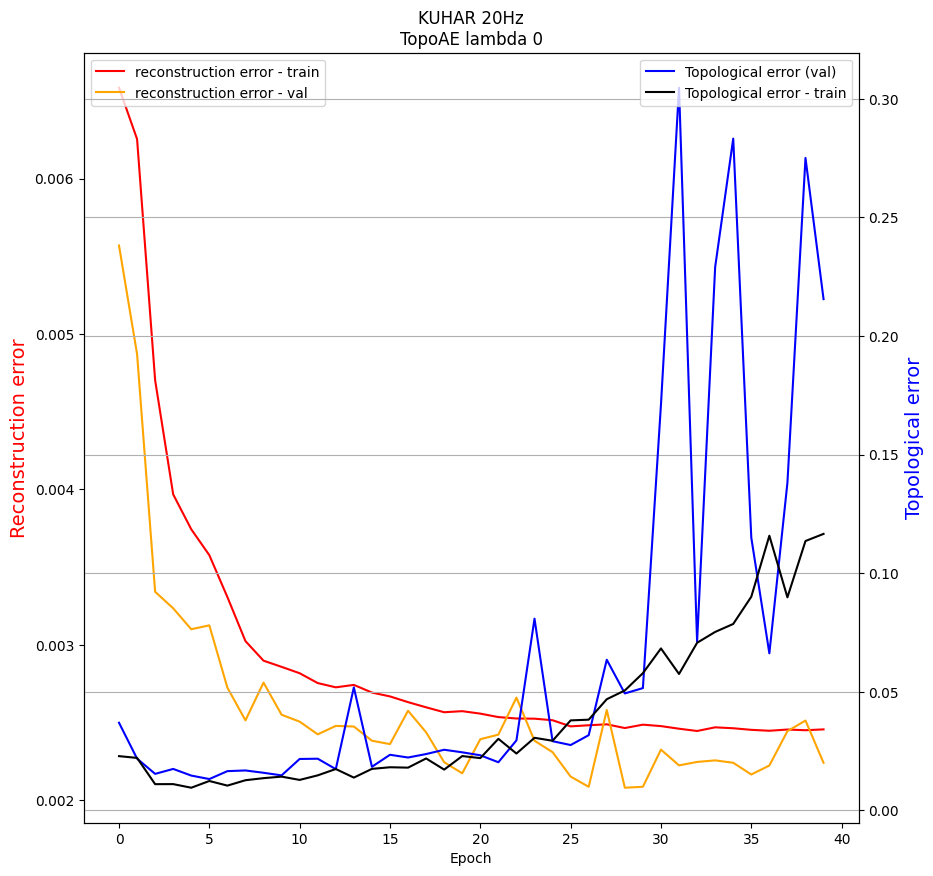

In [19]:
title_plot = "KUHAR 20Hz\nTopoAE lambda 0"
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [21]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [25]:
reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

In [29]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)
result = multi_run_experiment(train_pmd, test_pmd)
print(result['runs'][])
print(yaml.dump(result, sort_keys=True, indent=4))

{'runs': [{'run id': 1, 'start': 1665487444.1709168, 'end': 1665487444.5473838, 'time taken': 0.3764669895172119, 'result': [{'accuracy': 0.09259259259259259, 'f1 score (weighted)': 0.12413054914885668, 'f1 score (micro)': 0.09259259259259259, 'f1 score (macro)': 0.06105463603632851}]}, {'run id': 2, 'start': 1665487444.547386, 'end': 1665487444.9208248, 'time taken': 0.37343883514404297, 'result': [{'accuracy': 0.09523809523809523, 'f1 score (weighted)': 0.12558018461464707, 'f1 score (micro)': 0.09523809523809523, 'f1 score (macro)': 0.06489600586154343}]}, {'run id': 3, 'start': 1665487444.9208267, 'end': 1665487445.2968917, 'time taken': 0.3760650157928467, 'result': [{'accuracy': 0.09788359788359788, 'f1 score (weighted)': 0.12616334655762043, 'f1 score (micro)': 0.09788359788359789, 'f1 score (macro)': 0.06960384920957535}]}]}
runs:
-   end: 1665487444.5473838
    result:
    -   accuracy: 0.09259259259259259
        f1 score (macro): 0.06105463603632851
        f1 score (micro):

In [ ]:


reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

# Topological AE

In [ ]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 1000
transform_topoae = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

In [ ]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
transform_topoae.fit(train_dataset_fft.X, train_dataset_fft.y, title_plot=title_plot)
# assert 1==0

In [ ]:
test_applied_topoae = transform_topoae.transform(test_dataset_fft.X)
print('ORIGINAL', test_applied_topoae.shape)
test_applied_topoae = np.reshape(test_applied_topoae, (-1,2))
print('RESHAPED', test_applied_topoae.shape)

In [ ]:
train_applied_topoae = transform_topoae.transform(train_dataset_fft.X)
print('ORIGINAL', train_applied_topoae.shape)
train_applied_topoae = np.reshape(train_applied_topoae, (-1,2))
print('RESHAPED', train_applied_topoae.shape)

In [ ]:
from librep.transforms import TSNE
import numpy as np
import matplotlib.pyplot as plt

def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()


In [ ]:
visualize(test_applied_topoae, test_dataset_fft.y)

In [ ]:
# filtered
filter_to_use = [0,1,2,3,4,5]
visualize(test_applied_topoae, test_dataset_fft.y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
for f in filter_to_use:
    visualize(test_applied_topoae, test_dataset_fft.y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
# visualize(test_applied_topoae, test_dataset_fft.y, filtered=[1])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

In [ ]:
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport
metrics_reporter = DimensionalityReductionQualityReport()
metrics_train_applied_topoae = metrics_reporter.evaluate([test_dataset_fft.X, test_applied_topoae])
print(metrics_train_applied_topoae)

In [ ]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

In [ ]:
combined_train_dset = PandasMultiModalDataset(
    pd.concat([train, validation]),
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)


result = multi_run_experiment(combined_train_dset, test_dataset)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
combined_train_dset_fft = transformer(combined_train_dset)

result = multi_run_experiment(combined_train_dset_fft, test_dataset_fft)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
print(train_dataset_fft.y)

print(combined_train_dset.data.shape)

In [ ]:
import pandas as pd

# Using the latent space
train_applied_topoae = transform_topoae.transform(train_dataset_fft.X)
print('ORIGINAL', train_applied_topoae.shape)
train_applied_topoae = np.reshape(train_applied_topoae, (-1,2))
print('RESHAPED', train_applied_topoae.shape)

train_applied_topoae_pd = pd.DataFrame(train_applied_topoae)
train_applied_topoae_pd['y'] = train_dataset_fft.y
# print('FINAL', train_applied_topoae_pd)


topoae_train_dset = PandasMultiModalDataset(
    train_applied_topoae_pd,
    label_columns="y",
    as_array=True
)

test_applied_topoae_pd = pd.DataFrame(test_applied_topoae)
test_applied_topoae_pd['y'] = test_dataset_fft.y
# print('FINAL', test_applied_topoae_pd)

topoae_test_dset = PandasMultiModalDataset(
    test_applied_topoae_pd,
    label_columns="y",
    as_array=True
)
result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

# SVC

In [ ]:
experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:

experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags ={'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))